In [1]:
import numpy as np
import math

In [3]:
#checking expected number of bb events:

#cross sections

lumi = 10000 #target lumi in pb^-1

cross_section_bb = 6654.46
bb_raw = 438738637
ninety_bb = 7203
bb_filter = (ninety_bb/0.9)/bb_raw

cross_section_4body = 0.014
body_raw = 100000
ninety_body = 4374
body_filter = (ninety_body/0.9)/body_raw

cross_section_cc = 5215.46
cc_raw = 499786495
ninety_cc = 1190
cc_filter = (ninety_cc/0.9)/cc_raw

N_filtered_bb_exp = (cross_section_bb * lumi / bb_raw) * bb_filter
N_filtered_body_exp = (cross_section_4body * lumi / body_raw) * body_filter
N_filtered_cc_exp = (cross_section_cc * lumi / cc_raw) * cc_filter

total_bkg = N_filtered_bb_exp + N_filtered_body_exp + N_filtered_cc_exp

print(f"bb at 10fb after filter; {N_filtered_bb_exp}")
print(f"4 body at 10fb after filter; {N_filtered_body_exp}")
print(f"cc at 10fb after filter; {N_filtered_cc_exp}")

print(f"total background after filter at 10 fb^-1 = {total_bkg}")

bb at 10fb after filter; 2.766763009832639e-06
4 body at 10fb after filter; 6.803999999999999e-05
cc at 10fb after filter; 2.76075608196409e-07
total background after filter at 10 fb^-1 = 7.108283861802903e-05


In [ ]:
base_path = "/eos/user/t/tcritchl/HNLs/stage1/"

masses = [
    "10GeV",
    "20GeV",
    "30GeV",
    "40GeV",
    "50GeV",
    "60GeV",
    "70GeV",
    "80GeV",   
]

couplings = [
    "1e-2", 
    "1e-2p5", 
    "1e-3", 
    "1e-3p5", 
    "1e-4", 
    "1e-4p5", 
    "1e-5"
]

#initialise list to store the files

signal_files = []

for mass in masses:
    for coupling in couplings:
        print(f"using mass: {mass}, coupling {coupling}")
        base_file = f"HNL_Dirac_ejj_{mass}_{coupling}Ve.root"
        signal_file = os.path.join(base_path, base_file)
        if os.path.exists(signal_file):
            signal_files.append([signal_file, f"signal_{mass}_{coupling}"]) #label will be of the form "signal_10GeV_1e-2"
        else:
            print(f"file {signal_file} does not exist, moving to next file")

print(signal_files)


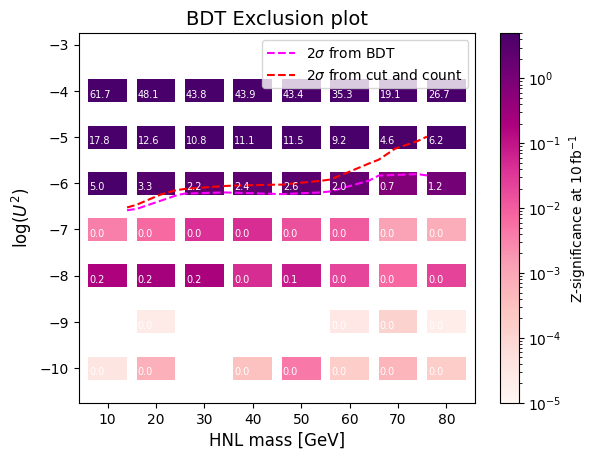

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results.json', 'r') as file:
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    
    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        
        highest_significance = max(value['significance_list'], key=lambda x: x[0])[0]
        data_points.append((mass, angle, highest_significance))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \, \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb.pdf', format='pdf')
    plt.show()

make_hist_2D()

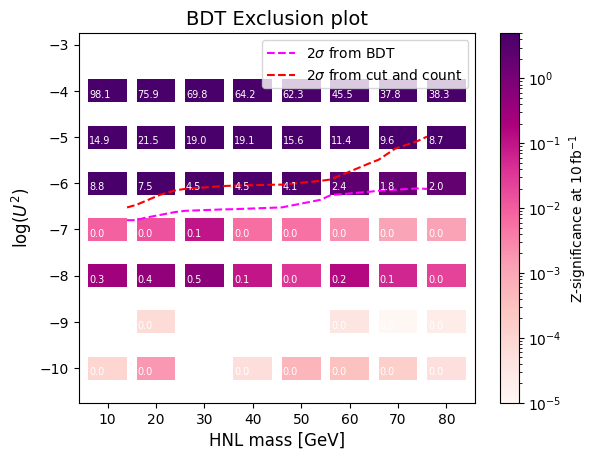

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results2.json', 'r') as file:
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    
    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        
        highest_significance = max(value['significance_list'], key=lambda x: x[0])[0]
        data_points.append((mass, angle, highest_significance))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \, \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb.pdf', format='pdf')
    plt.show()

make_hist_2D()

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results3.json', 'r') as file:
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    
    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        
        highest_significance = max(value['significance_list'], key=lambda x: x[0])[0]
        data_points.append((mass, angle, highest_significance))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \, \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb.pdf', format='pdf')
    plt.show()

make_hist_2D()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_1206/535869921.py:77: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_1206/535869921.py:78: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices


Area enclosed by BDT 2σ contour: -399.20573375664276
Area enclosed by Cut and Count 2σ contour: -365.77418875422234
Difference in areas: -33.43154500242042
Percentage Improvement: 9.14%


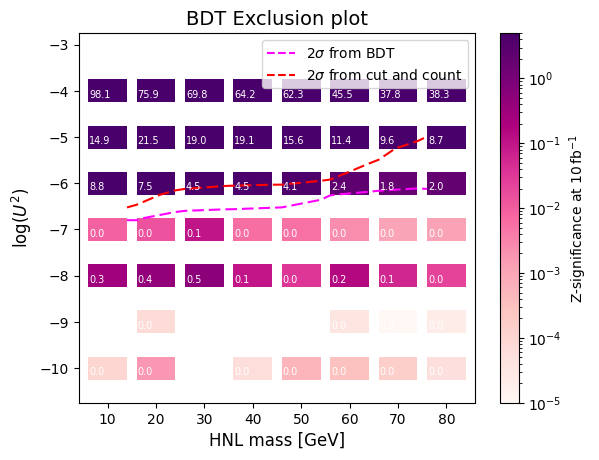

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results2.json', 'r') as file:
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    
    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        
        highest_significance = max(value['significance_list'], key=lambda x: x[0])[0]
        data_points.append((mass, angle, highest_significance))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \, \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb.pdf', format='pdf')
    plt.show()

make_hist_2D()

/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_4794/378956826.py:77: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_4794/378956826.py:78: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices


Area enclosed by BDT 2σ contour: -397.1451613341439
Area enclosed by Cut and Count 2σ contour: -365.77418875422234
Difference in areas: -31.370972579921556
Percentage Improvement: 8.58%


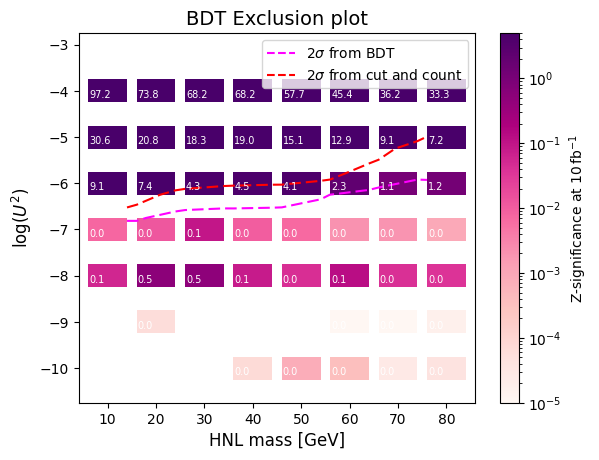

In [1]:
### plot for D0 inc, between 0.8 and 1.0, 2000 bins ###
### 30 GeV filter on the lead electron energy , LR significance (from right most bin to left most bin) ###

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results4.json', 'r') as file:
    
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        
        highest_significance = max(value['significance_list'], key=lambda x: x[0])[0]
        data_points.append((mass, angle, highest_significance))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \, \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb.pdf', format='pdf')
    plt.show()

make_hist_2D()

/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_76303/6882222.py:82: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_76303/6882222.py:83: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices


Area enclosed by BDT 2σ contour: -403.49813762798544
Area enclosed by Cut and Count 2σ contour: -365.77418875422234
Difference in areas: -37.723948873763106
Percentage Improvement: 10.31%


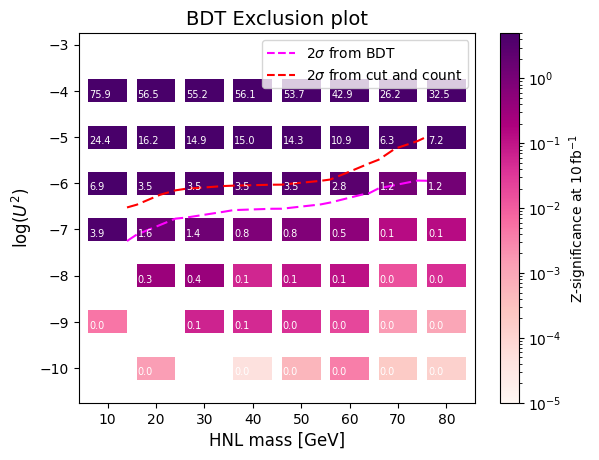

In [3]:
### 28 Feb new plot with new HNLs i hope its better dear god ###

### plot for D0 inc, between 0.8 and 1.0, 2000 bins ###
### 30 GeV filter on the lead electron energy , LR significance (from right most bin to left most bin) ###

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results6_10fb.json', 'r') as file:
    
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        
        highest_significance = max(value['significance_list'], key=lambda x: x[0])[0]
        data_points.append((mass, angle, highest_significance))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \, \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb.pdf', format='pdf')
    plt.show()

make_hist_2D()

bdt cuts list [0.9931999316824351, 0.9999999990098902, 0.999999999009891, 0.9999999990098902, 0.9997999970296706, 0.9998999980197805, 0.9997999966762879, 0.9999999990098903, 0.9918999188112214, 0.9999999990098902, 0.9999999990098902, 0.9998999980197805, 0.9999999990098902, 0.9998999958994844, 0.9999999990098902, 0.9995999950494571, 0.9461994663315733, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9998999980197804, 0.9989999878130559, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.999699995097207, 0.9996999960395608, 0.9993999930692316, 0.9977999772274747, 0.9999999990098902, 0.9994999940593456, 0.999899997313015, 0.9999999990098902, 0.0, 0.8989989394572425, 0.999899997784192, 0.9999999990098902, 0.9994999937059585, 0.9997999970296707, 0.999899997784192, 0.9998999980197804, 0.9999999990098905, 0.9998999980197806, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.999599995049451, 0.9999999990098902, 0.9999999990098902, 0.9998

/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_1812/1533610904.py:89: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_1812/1533610904.py:90: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices


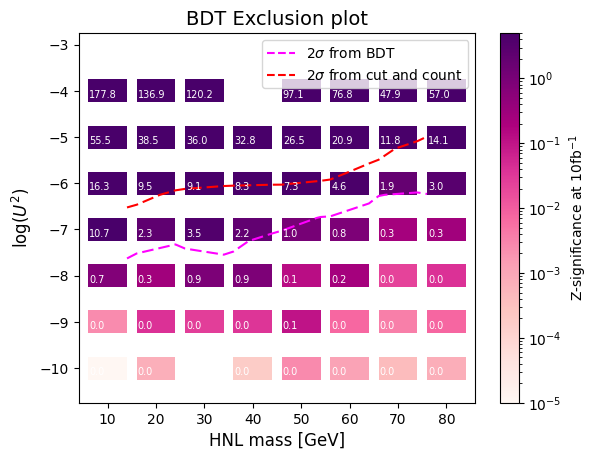

In [88]:
## run 7 ##

### 28 Feb new plot with new HNLs i hope its better dear god ###

### plot for D0 inc, between 0.8 and 1.0, 2000 bins ###
### 30 GeV filter on the lead electron energy , LR significance (from right most bin to left most bin) ###

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results6_10fb.json', 'r') as file:
    
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        highest_significance_entry = max(value['significance_list'], key=lambda x: x[0])
        highest_significance = highest_significance_entry[0]
        bdt_cut = highest_significance_entry[2]  # Third entry of the significance_list

        data_points.append((mass, angle, highest_significance, bdt_cut))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]
    bdt_cuts = [data[3] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    print(f"bdt cuts list {bdt_cuts}")

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb_run7.pdf', format='pdf')
    plt.show()

make_hist_2D()


bdt cuts list [0.9998999980197896, 0.9987999603529161, 0.9272992792310621, 0.8989956677920263, 0.037037037037037035, 0.898919219979908, 0.0, 0.9183922142371095, 0.9306992311643649, 0.9950999475716549, 0.9978999769392959, 0.9458994314411359, 0.001001001001001001, 0.8989377767621359, 0.8989989989993271, 0.9153869914425585, 0.9747977826242481, 0.9998999980197867, 0.9997999970297184, 0.9298991809399352, 0.9018605092868798, 0.9547961901490638, 0.9726926767757023, 0.9999999990098959, 0.9998999980199492, 0.9997999970300407, 0.8989364738615371, 0.9932999326725636, 0.9991999910890119, 0.9989999891087951, 0.9995999950494512, 0.9999999990098934, 0.9998999980197827, 0.9888998561284428, 0.999499993706715, 0.9995999794424446, 0.9974995301782063, 0.9985999586447558, 0.9998999979020196, 0.9984999841583092, 0.998899988118683, 0.9994999940593419, 0.9911981296621741, 0.9892903372795734, 0.9977999745182253, 0.9996999852032961, 0.9987999794769467, 0.9998999980200347, 0.9899968199917666, 0.9921999031700942,

/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_7096/2390144288.py:91: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_7096/2390144288.py:92: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices


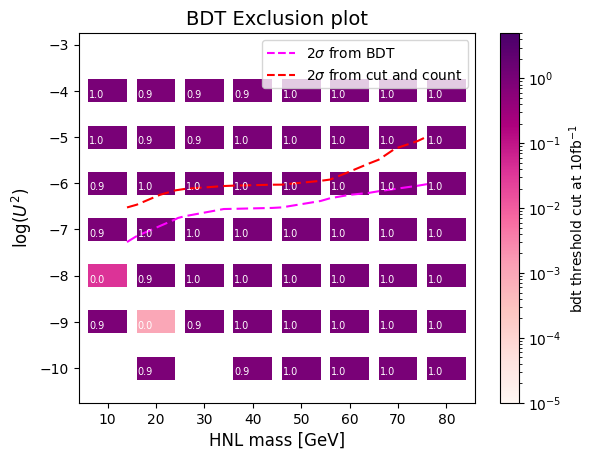

In [7]:
# bdt cut list #

## run 7 ##

### 28 Feb new plot with new HNLs i hope its better dear god ###

### plot for D0 inc, between 0.8 and 1.0, 2000 bins ###
### 30 GeV filter on the lead electron energy , LR significance (from right most bin to left most bin) ###

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results7_10fb.json', 'r') as file:
    
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        highest_significance_entry = max(value['significance_list'], key=lambda x: x[0])
        highest_significance = highest_significance_entry[0]
        bdt_cut = highest_significance_entry[2]  # Third entry of the significance_list

        data_points.append((mass, angle, highest_significance, bdt_cut))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]
    bdt_cuts = [data[3] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    print(f"bdt cuts list {bdt_cuts}")

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=bdt_cuts, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=bdt_cuts)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'bdt threshold cut at $10 \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb_run7.pdf', format='pdf')
    plt.show()

make_hist_2D()



means for the variable are [0.5460000038146973, 0.546999990940094, 0.5450000166893005, 0.5339999794960022, 737.4310302734375, 1414.2139892578125, 1414.2139892578125, 1.1109999418258667, 1.11899995803833, 1.1239999532699585, 1.1239999532699585, 1.121999979019165, 1.0839999914169312, 885.2349853515625, 1.6059999465942383, 1.6059999465942383, 1.6180000305175781, 1.6200000047683716, 1.6180000305175781, 1.621000051498413, 1.9450000524520874, 1.9450000524520874, 1.9450000524520874, 1.9589999914169312, 1.9589999914169312, 1.9609999656677246, 1.975000023841858, 2.184999942779541, 2.187999963760376, 2.186000108718872, 2.190999984741211, 2.1989998817443848, 2.197000026702881, 2.203000068664551, 2.378999948501587, 2.378999948501587, 2.378999948501587, 2.378999948501587, 2.3889999389648438, 2.3889999389648438, 2.385999917984009, 2.5869998931884766, 2.5869998931884766, 2.5869998931884766, 2.5869998931884766, 2.5880000591278076, 2.5950000286102295, 2.5950000286102295, 2.9110000133514404, 2.911000013

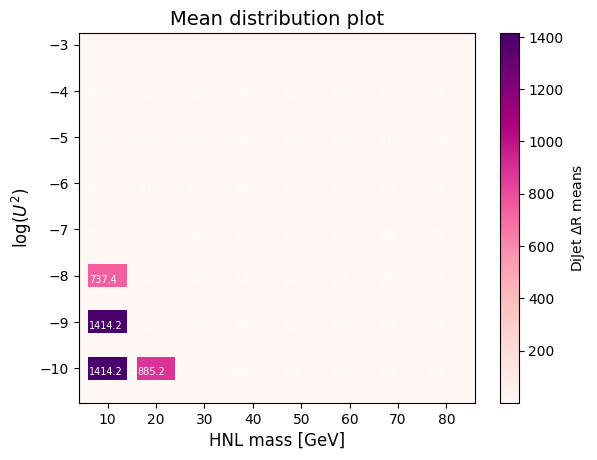

In [84]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('signal_means.json', 'r') as file:
    data = json.load(file)
    
def make_hist_2D():
    # 10 fb-1 data
    data_points = []
    variable = "RecoDiJet_delta_R"
    means = []  # Define means list here

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        means.append(value.get(variable, 0))  # Append mean values

        data_points.append((mass, angle))

    masses = [data[0] for data in data_points]
    angles = [data[1] * 2 for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    print(f"means for the variable are {means}")

    norm = Normalize(vmin=min(means), vmax=max(means))

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=means, cmap=cmap, norm=norm, density=False)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=means)
    x_edges, y_edges = edges
    
    plt.colorbar(label=f'DiJet $\Delta$R means')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("Mean distribution plot", fontsize=14)

    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    plt.savefig(f'{variable}_mean.pdf', format='pdf')
    plt.show()

make_hist_2D()


bdt cuts list [0.9931999316824351, 0.9999999990098902, 0.999999999009891, 0.9999999990098902, 0.9997999970296706, 0.9998999980197805, 0.9997999966762879, 0.9999999990098903, 0.9918999188112214, 0.9999999990098902, 0.9999999990098902, 0.9998999980197805, 0.9999999990098902, 0.9998999958994844, 0.9999999990098902, 0.9995999950494571, 0.9461994663315733, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9998999980197804, 0.9989999878130559, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.999699995097207, 0.9996999960395608, 0.9993999930692316, 0.9977999772274747, 0.9999999990098902, 0.9994999940593456, 0.999899997313015, 0.9999999990098902, 0.0, 0.8989989394572425, 0.999899997784192, 0.9999999990098902, 0.9994999937059585, 0.9997999970296707, 0.999899997784192, 0.9998999980197804, 0.9999999990098905, 0.9998999980197806, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9992999916079451, 0.999599995049451, 0.9999999990098902, 0.9999

/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_1812/1300613578.py:89: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_1812/1300613578.py:90: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices


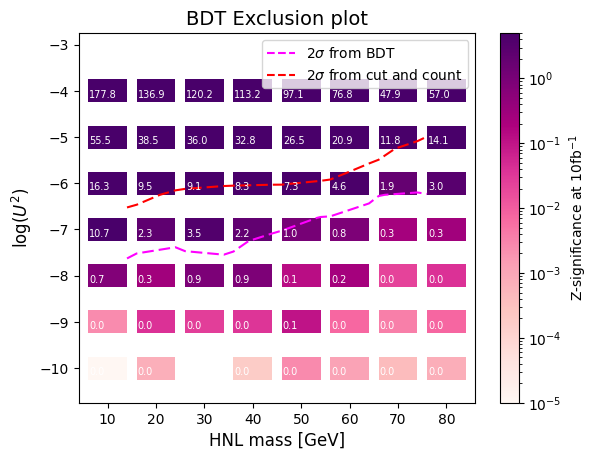

In [91]:
## run 7 ##

### 28 Feb new plot with new HNLs i hope its better dear god ###

### plot for D0 inc, between 0.8 and 1.0, 2000 bins ###
### 30 GeV filter on the lead electron energy , LR significance (from right most bin to left most bin) ###

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results10_10fb.json', 'r') as file:
    
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        highest_significance_entry = max(value['significance_list'], key=lambda x: x[0])
        highest_significance = highest_significance_entry[0]
        bdt_cut = highest_significance_entry[2]  # Third entry of the significance_list

        data_points.append((mass, angle, highest_significance, bdt_cut))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]
    bdt_cuts = [data[3] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    print(f"bdt cuts list {bdt_cuts}")

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb_run10.pdf', format='pdf')
    plt.show()

make_hist_2D()


bdt cuts list [0.9999999990098902, 0.9998999979019862, 0.9999999990098902, 0.9999999990098902, 0.9998999980197804, 0.9998999980197804, 0.9998999979019861, 0.9999999990098902, 0.9999999990098902, 0.9998999980197804, 0.9997999970296708, 0.9998999980197805, 0.9998999980197804, 0.9998999979019861, 0.9998999980197804, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9998999979019861, 0.0, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9997999970296708, 0.9999999990098902, 0.9998999980197804, 0.9999999990098902, 0.9996999960395608, 0.9998999979019862, 0.9999999990098902, 0.9999999990098902, 0.9996999960395608, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9996999960395613, 0.992599925741767, 0.9999999990098902, 0.9998999980197805, 0.9999999990098902, 0.9999999990098902, 0.9998999980197805, 0

/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_32261/18316951.py:86: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_32261/18316951.py:87: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices


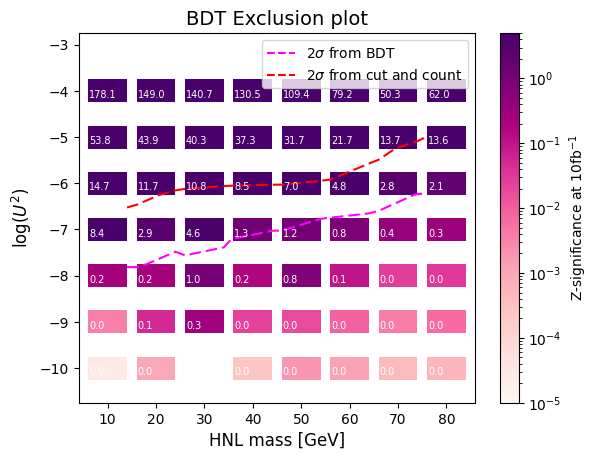

In [3]:
## RUN 11 -- 15 GeV Filter -- ##

## 22 March 2024 ##

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results11_10fb.json', 'r') as file:
    
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        highest_significance_entry = max(value['significance_list'], key=lambda x: x[0])
        highest_significance = highest_significance_entry[0]
        bdt_cut = highest_significance_entry[2]  # Third entry of the significance_list

        data_points.append((mass, angle, highest_significance, bdt_cut))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]
    bdt_cuts = [data[3] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    print(f"bdt cuts list {bdt_cuts}")

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb_run11.pdf', format='pdf')
    plt.show()

make_hist_2D()


bdt cuts list [0.9999999990098902, 0.9998999980197804, 0.9999999990098902, 0.9493994980143374, 0.9998999980197804, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9998999980197804, 0.9999999990098902, 0.9999999990098902, 0.9997999970296706, 0.9999999990098902, 0.0, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9999999990098905, 0.9999999990098902, 0.9996999960395608, 0.9999999990098902, 0.9999999990098902, 0.9990999900989026, 0.9999999990098902, 0.9998999980197805, 0.9999999990098902, 0.9999999990098902, 0.9361993673204251, 0.9998999980197804, 0.9999999990098902, 0.9999999990098902, 0.9999999990098902, 0.9998999980197805, 0.9999999990098902, 0.9997999970296706, 0.9995999950494511, 0.9997999970296706, 0.9999999990098902, 0.9998999980197804, 

/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_32261/2913171110.py:87: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_32261/2913171110.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices


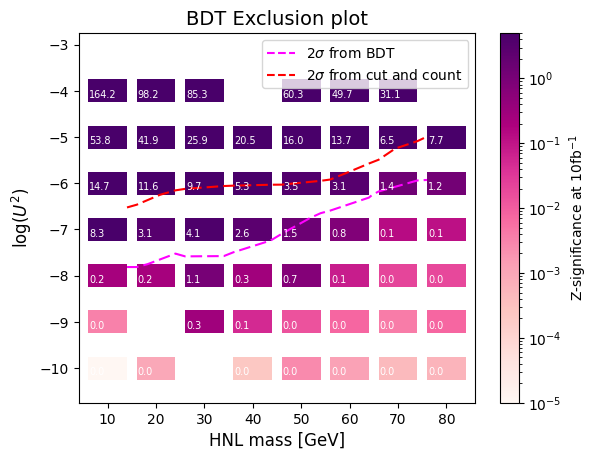

In [2]:
## RUN 12 Prompt Decay ###
## RUN 11 -- 15 GeeV Filter -- ##

## 22 March 2024 ##

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results12_10fb.json', 'r') as file:
    
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        highest_significance_entry = max(value['significance_list'], key=lambda x: x[0])
        highest_significance = highest_significance_entry[0]
        bdt_cut = highest_significance_entry[2]  # Third entry of the significance_list

        data_points.append((mass, angle, highest_significance, bdt_cut))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]
    bdt_cuts = [data[3] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    print(f"bdt cuts list {bdt_cuts}")

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb_run12_LLP.pdf', format='pdf')
    plt.show()

make_hist_2D()



bdt cuts list [0.9976999635155909, 0.8989989989989993, 0.9985998817839483, 0.9868998615310913, 0.9995999947549663, 0.9992999911367703, 0.9991999714762738, 0.9934999229911363, 0.9993999584377294, 0.9998999980197804, 0.9999999990098902, 0.9995999929880564, 0.9998999955461018, 0.9999999990098902, 0.898998998998999, 0.9998999980197805, -0.07025640797778283, 0.9995999882762832, 0.9990999783194837, 0.9993999914201132, 0.9996999943904417, 0.9978999574858024, 0.9924996517046435, 0.9999999990098902, 0.1021021021021021, 0.9675974386516246, 0.999099988331999, 5.047693674786746e-05, 0.8989984035493993, 0.9966998682136874, 0.9999999990098902, 0.9995999891597427, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.8989967958347644, 0.

/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_87821/2148602771.py:89: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
/var/folders/1l/7dk3svz97wdcq01rlzd7rzpc0000gn/T/ipykernel_87821/2148602771.py:90: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cc_points = cc_2sigma.collections[0].get_paths()[0].vertices


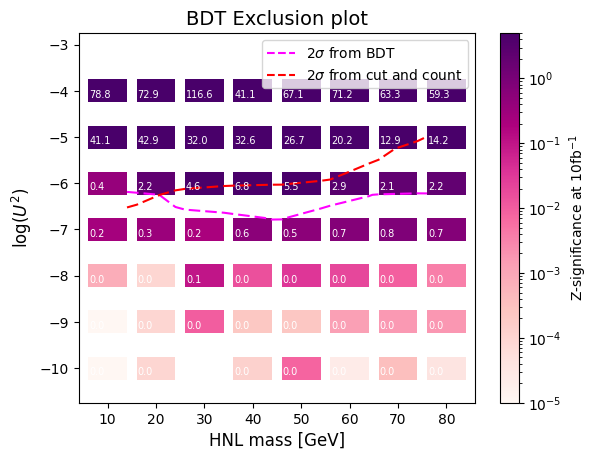

In [26]:
## RUN 13 should extend to higher masses ##

## RUN 12 Prompt Decay ###
## RUN 11 -- 15 GeeV Filter -- ##

## 22 March 2024 ##

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
import json
from sklearn.metrics import auc

with open('test_xgboost_results13_10fb.json', 'r') as file:
    
    data = json.load(file)
    
def make_hist_2D():

    #10 fb-1 data

    #data_points = [('10', -4.0, 27.778574889916563), ('10', -5.0, 7.9098872059916365), ('10', -6.0, 2.321909727607213), ('10', -7.0, 0.0009543498604278071), ('10', -8.0, 0.05579593603714217), ('10', -9.0, 6.016719461905977e-08), ('10', -10.0, 8.675845754470089e-06), ('20', -4.0, 17.845892334515295), ('20', -5.0, 5.108197588635191), ('20', -6.0, 1.0769853307552089), ('20', -7.0, 0.0018679408941489326), ('20', -8.0, 0.01952953104055794), ('20', -9.0, 6.401283052342732e-07), ('20', -10.0, 1.7086127338175105e-05), ('30', -4.0, 16.2862566546243), ('30', -5.0, 3.8699231500332623), ('30', -6.0, 0.7338425118418546), ('30', -7.0, 0.001109623620388535), ('30', -8.0, 0.010895638995044797), ('40', -4.0, 15.281028458541495), ('40', -5.0, 3.69548224976052), ('40', -6.0, 0.7348459050973114), ('40', -7.0, 0.0011912950804715996), ('40', -8.0, 0.011769179453659795), ('40', -10.0, 0), ('50', -4.0, 14.290300427271251), ('50', -5.0, 3.668737074259249), ('50', -6.0, 0.8216503610726512), ('50', -7.0, 0.0018133807230021758), ('50', -8.0, 0.01768896886838045), ('50', -10.0, 0), ('60', -4.0, 10.520843819835253), ('60', -5.0, 2.6176704965000233), ('60', -6.0, 0.5547729100572643), ('60', -7.0, 0.0010488922154181857), ('60', -8.0, 0.01024677129570917), ('60', -9.0, 1.0833692200417029e-05), ('60', -10.0, 0.00010498732308894972), ('70', -4.0, 5.771373976106098), ('70', -5.0, 1.31711669256286), ('70', -6.0, 0.24014289367746705), ('70', -7.0, 0.00033557696678828986), ('70', -8.0, 0.003338965933987431), ('70', -9.0, 3.3597480736752614e-06), ('70', -10.0, 3.3733149035896306e-05), ('80', -4.0, 0.4087316635166447), ('80', -5.0, 0.055734614012993344), ('80', -6.0, 0.005953706853334397), ('80', -7.0, 9.877514849343938e-06), ('80', -8.0, 6.052385900507629e-05), ('80', -9.0, 1.0858669922899504e-07), ('80', -10.0, 6.372843482819998e-07)]

    data_points = []

    for key, value in data.items():
        parts = key.split('_')
        mass = float(parts[1].replace('GeV', ''))  # Just take the number
        
        # Replace '1e-' with '-' and 'p' with '.'
        angle = float(parts[2].replace('1e-', '-').replace('p', '.'))
        highest_significance_entry = max(value['significance_list'], key=lambda x: x[0])
        highest_significance = highest_significance_entry[0]
        bdt_cut = highest_significance_entry[2]  # Third entry of the significance_list

        data_points.append((mass, angle, highest_significance, bdt_cut))

    masses = [float(data[0]) for data in data_points]
    angles = [float(data[1] * 2) for data in data_points]
    #angles = [angle * 2 for angle in angles]  # Angle squared is 10^(2 * exponent)
    significances = [data[2] for data in data_points]
    bdt_cuts = [data[3] for data in data_points]

    x_range = (0, 90)
    y_range = (-11, -3)
    
    x_bins = [4, 6, 14, 16, 24, 26, 34, 36, 44, 46, 54, 56, 64, 66, 74, 76, 84, 86]
    y_bins = np.arange(-10.75, -2.25, 0.5)

    n_bins = [x_bins, y_bins]

    print(f"bdt cuts list {bdt_cuts}")

    norm = LogNorm(vmin=1e-5, vmax=5)

    cmap = plt.cm.RdPu

    plt.hist2d(masses, angles, bins=n_bins, range=[x_range, y_range], weights=significances, cmap=cmap, norm=norm)

    hist, edges = np.histogramdd((masses, angles), bins=n_bins, range=[x_range, y_range], weights=significances)
    x_edges, y_edges = edges
    
    plt.colorbar(label = 'Z-significance at $10 \mathrm{fb}^{-1}$')
    #plt.colorbar.set_label("Z significance at  $150 \, \mathrm{ab}^{-1}$", fontsize = 12)
    ###delimiting line
    threshold = 2.0
    x_grid, y_grid = np.meshgrid(x_bins, y_bins)

    ###former data from cut and count (cc)###

    data_points_cc = [["10", -4.0, 52.876748861276596], ["10", -5.0, 15.128775602656333], ["10", -6.0, 4.4804573585508045], ["10", -7.0, 0.001475996382017464], ["10", -8.0, 0.08968425151707608], ["10", -9.0, 5.99037429924615e-08], ["10", -10.0, 1.4097477838218989e-05], ["20", -4.0, 36.2857862213626], ["20", -5.0, 10.884431421876464], ["20", -6.0, 2.4678689415467248], ["20", -7.0, 0.004537376980651871], ["20", -8.0, 0.058997010448686465], ["20", -9.0, 1.163004130746887e-06], ["20", -10.0, 3.352827837383747e-05], ["30", -4.0, 32.92212247543547], ["30", -5.0, 8.315052417103097], ["30", -6.0, 1.7459934119249754], ["30", -7.0, 0.0033373434392724114], ["30", -8.0, 0.029476881359299892], ["40", -4.0, 29.429788400754102], ["40", -5.0, 7.506664142646672], ["40", -6.0, 1.5869986460516172], ["40", -7.0, 0.0029276961561613734], ["40", -8.0, 0.02821520628356613], ["40", -10.0, 0], ["50", -4.0, 25.62219372240296], ["50", -5.0, 6.763465781950523], ["50", -6.0, 1.5570028443548596], ["50", -7.0, 0.003920231273620948], ["50", -8.0, 0.03817629371414823], ["50", -10.0, 0], ["60", -4.0, 18.866071450665995], ["60", -5.0, 4.839367338887292], ["60", -6.0, 1.0775817568201167], ["60", -7.0, 0.00230040705768753], ["60", -8.0, 0.022811124653626037], ["60", -9.0, 2.3613377004847655e-05], ["60", -10.0, 0.0002345337086266546], ["70", -4.0, 11.254577646746137], ["70", -5.0, 2.7412790459120084], ["70", -6.0, 0.5486607337910216], ["70", -7.0, 0.0008222118582734013], ["70", -8.0, 0.008246616737636249], ["70", -9.0, 8.055020468869638e-06], ["70", -10.0, 8.326387828664493e-05], ["80", -4.0, 0.6762462099536374], ["80", -5.0, 0.09792341746750198], ["80", -6.0, 0.010659487433272599], ["80", -7.0, 9.878873485179866e-06], ["80", -8.0, 0.00010780352635664964], ["80", -9.0, 1.508599479535031e-07], ["80", -10.0, 1.2065998272242434e-06]]

    masses_cc = [float(data[0]) for data in data_points_cc]
    angles_cc = [float(data[1]) for data in data_points_cc]
    significances_cc = [data[2] for data in data_points_cc]

    # Perform the interpolation
    z_interp = griddata((masses, angles), significances, (x_grid, y_grid), method='linear')
    z_cut_count = griddata((masses_cc, angles_cc), significances_cc, (x_grid, y_grid), method='linear')
    # Contour lines
    contour_2sigma = plt.contour(x_grid, y_grid, z_interp, levels=[threshold], colors='magenta', linestyles='dashed')
    
    cc_2sigma = plt.contour(x_grid, y_grid, z_cut_count, levels=[threshold], colors='red', linestyles='dashed')
    #contour_5sigma = plt.contour(x_grid, y_grid, z_interp, levels=[5.0], colors='blue')
    
    # Identify the coordinates of the 2σ contours
    contour_points = contour_2sigma.collections[0].get_paths()[0].vertices
    cc_points = cc_2sigma.collections[0].get_paths()[0].vertices

    # Calculate the area enclosed by the contours
    area_contour = auc(contour_points[:, 0], contour_points[:, 1])
    area_cc = auc(cc_points[:, 0], cc_points[:, 1])

    # Find the difference in areas
    area_difference = area_contour - area_cc

    print(f"Area enclosed by BDT 2σ contour: {area_contour}")
    print(f"Area enclosed by Cut and Count 2σ contour: {area_cc}")
    print(f"Difference in areas: {area_difference}")
    # Find the difference in areas
    percentage_improvement = (area_difference / area_cc) * 100

    print(f"Percentage Improvement: {percentage_improvement:.2f}%")
    
    # Create legend entries
    legend_elements = [Line2D([0], [0], color='magenta', linestyle='dashed', label='2$\sigma$ from BDT'),
                       Line2D([0], [0], color='red', linestyle='dashed', label='2$\sigma$ from cut and count')]
                       #Line2D([0], [0], color='blue', label='5$\sigma$')]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("HNL mass [GeV]", fontsize=12)
    plt.ylabel("log($U^2$)", fontsize=12)
    plt.title("BDT Exclusion plot", fontsize=14)

    
    for i in range(len(x_edges) -1):
        for j in range(len(y_edges) -1):
            if hist[i, j] > 0:
                plt.text(x_edges[i] +0.2, y_edges[j]+0.1, f'{hist[i, j]:.1f}', color='white', fontsize = 7)

    
    plt.savefig('exclusionplot_10fb_run13_LLP.pdf', format='pdf')
    plt.show()

make_hist_2D()

